## Real-Time and Asynchronous Agentic LLM systems powered by LangGraph

In [ ]:
"""
# Experimental title:
Streaming and Non-Streaming Agentic LLM workflows with Tool integration using LangGraph

# Primary goal:
The main goal of this project is to make an Agentic LLM pipeline. When running this pipeline, it supports the following facts.
•	Connect outside tools such web search to LLM thought process.
•	Use LangGraph to facilitate context as well as tool optimized agent operation.
•	Accommodate both streaming and non-streaming processing modes.
•	Present real-time results gathering for most recent user queries.
•	Show how to make operational LLM pipelines.

# System components
•	Jupyter Notebook (Python)                                                                                                                      
•	LangGraph | LangChain
•	LLM (gpt-4o-mini) | Tavily search api 
•	Agentic AI frameworks
•	Streaming | non-streaming LLM Inference
•	Query configuration

# Main Features:
•	Agentic LLM configuration with tools.
•	Agentic process pipeline with LangGraph.
•	Streaming and non-streaming Agentic mode. 
•	Situational tool engagement. 
•	Coordinating conversation state.
•	Real world query interpretation.

# Project file:
Advanced_LLM_Tool_Embedding_LangGraph.jpynb

"""

In [ ]:
"""
I installed all necessary libraries using the anaconda prompt and then run this project in jupyter notebook. 

"""

In [1]:
import os

In [3]:
# Load openai api key
from dotenv import load_dotenv

In [4]:
load_dotenv()
openapi_key = os.getenv('OPENAI_API_KEY')

In [7]:
# Load tavily search api key

tavily_api_key = os.getenv('TAVILY_API_KEY')

### Setup Enhanced LLM with LangGraph

In [10]:
from typing import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages

class Agent_State(TypedDict):
    messages:Annotated[list, add_messages]
    user_input:str

In [13]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
web_search_service = TavilySearchAPIWrapper()

from langchain_core.tools import tool
@tool
def internet_search(query: str, result_count: int = 3):
    '''
    Gather real-time data according to the user’s query.
    '''
    output = web_search_service.raw_results(max_results = result_count, search_depth = 'advanced', query=query, include_raw_content=True,)
    return output

In [16]:
from langchain_openai import ChatOpenAI
llm_gpt_mini = ChatOpenAI(model = 'gpt-4o-mini', temperature = 0.2)
agent_tools = [internet_search]
llm_gpt_mini_agent_tools = llm_gpt_mini.bind_tools(agent_tools)

C:\Users\gobin\anaconda3\envs\rag_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
def dialogue_node(state: Agent_State):
    result = llm_gpt_mini_agent_tools.invoke(state['messages'])
    return {'messages': [result]}


In [21]:
from langgraph.graph import StateGraph
routing_rag_graph = StateGraph(Agent_State)
routing_rag_graph.add_node('dialogue_node', dialogue_node)

In [23]:
from langgraph.graph import START
routing_rag_graph.add_edge(START, 'dialogue_node')

from langgraph.graph import END
routing_rag_graph.add_edge('dialogue_node', END)

In [25]:
rag_workflow_graph = routing_rag_graph.compile()

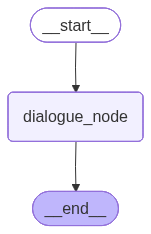

In [27]:
from IPython.display import display, Image
display(Image(rag_workflow_graph.get_graph().draw_mermaid_png()))

### Check the workflow involved in LLM with LangGraph

In [29]:
result = rag_workflow_graph.invoke({'messages': [{'role': 'user', 'content': 'Provide some information about electrical vehicles in USA in a short paragraph. '}],
                                    'user_input': 'Provide some information about electrical vehicles in USA in a short paragraph.'})

print(result['messages'][-1].content)

Electric vehicles (EVs) in the USA have seen significant growth in recent years, driven by advancements in battery technology, increased consumer awareness of environmental issues, and government incentives. As of 2023, EVs account for a growing share of new vehicle sales, with major automakers expanding their electric offerings. The federal government, along with various states, has implemented tax credits and rebates to encourage EV adoption. Additionally, the expansion of charging infrastructure is making it easier for consumers to transition to electric vehicles. This shift is part of a broader effort to reduce greenhouse gas emissions and promote sustainable transportation.


### Streaming and non-streaming Agentic LLM workflows with tool integration

In [31]:
from langgraph.prebuilt import ToolNode, tools_condition

In [33]:
llm_agent_tools = llm_gpt_mini.bind_tools(agent_tools)

In [35]:
def llm_agent_node(state: Agent_State) -> Agent_State:
    messages = state['messages']
    output = llm_agent_tools.invoke(messages)
    return {'messages': [output]}

In [37]:
from langgraph.prebuilt import ToolNode
toolsnode_agent_tools = ToolNode(tools=agent_tools)

In [39]:
pipeline = StateGraph(Agent_State)

In [41]:
pipeline.add_node('llm_agent_node', llm_agent_node)
pipeline.add_node('tools', toolsnode_agent_tools)

In [43]:
pipeline.add_edge(START, 'llm_agent_node')

In [45]:
pipeline.add_conditional_edges('llm_agent_node', tools_condition,['tools', END])

In [47]:
pipeline.add_edge('tools', END)


In [49]:
rag_workflow_graph = pipeline.compile()

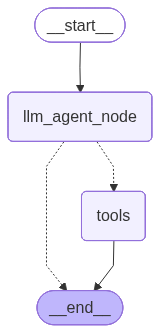

In [51]:
from IPython.display import display, Image
display(Image(rag_workflow_graph.get_graph().draw_mermaid_png()))

### see real-time results through all steps while running the graph

In [53]:
user_prompt = "Provide some latest information about electric vehicles in the USA in a short paragraph"

for stream_item in rag_workflow_graph.stream({'messages': [{'role': 'user', 'content': user_prompt}], 'user_input': user_prompt}, stream_mode = 'values'):
    stream_item['messages'][-1].pretty_print()

================================ Human Message =================================

Provide some latest information about electric vehicles in the USA in a short paragraph
================================== Ai Message ==================================
Tool Calls:
  internet_search (call_CWHV9rI49v6IxnFHMh9I4onx)
 Call ID: call_CWHV9rI49v6IxnFHMh9I4onx
  Args:
    query: latest information about electric vehicles in the USA
    result_count: 3
================================= Tool Message =================================
Name: internet_search

{"query": "latest information about electric vehicles in the USA", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.cnbc.com/2025/12/23/evs-gm-ford-hyundai-tesla.html", "title": "EV realism is here. How automakers react in 2026 will be telling", "content": "PwC expects the EV industry to pick up toward the end of this decade, with EVs forecast to make up 19% of the U.S. industry by 2030.", "score": 0.444

### See only final response after completing all steps through the whole graph

In [57]:
user_prompt = "Provide some latest information about electric vehicles in the USA in a short paragraph"

result = rag_workflow_graph.invoke({'messages': [{'role': 'user', 'content': user_prompt}],'user_input': user_prompt})

print(result['messages'][-1].content)

{"query": "latest information about electric vehicles in the USA", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.cnbc.com/2025/12/23/evs-gm-ford-hyundai-tesla.html", "title": "EV realism is here. How automakers react in 2026 will be ...", "content": "PwC expects the EV industry to pick up toward the end of this decade, with EVs forecast to make up 19% of the U.S. industry by 2030.", "score": 0.4286405, "raw_content": null}, {"url": "https://insideevs.com/", "title": "InsideEVs | Electric Vehicle News, Reviews, and Reports", "content": "We don't just publish the breaking news of the day, but go behind it, create it, and most importantly, examine the how, what and why of electric vehicles.", "score": 0.31122845, "raw_content": null}, {"url": "https://www.irs.gov/credits-deductions/credits-for-new-clean-vehicles-purchased-in-2023-or-after", "title": "Credits for new clean vehicles purchased in 2023 or after - IRS", "content": "You may qualify 